<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [1]:
#!pip install keras-core --upgrade
#!pip install -q keras-nlp --upgrade

In [2]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-11-18 14:19:36.402241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 14:19:37.340218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/cudnn-8.2.0.53-11.3-3qb34ykh5rffuzu6j3rl4tm6yarrjg7w/lib64:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/cuda-11.3.1-oqzddj7nezymwww6ennwec7qb6kktktw/lib64::/usr/local/cuda-12.6/lib64
2024-11-18 14:19:37.340388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Using TensorFlow backend
TensorFlow version: 2.11.0
KerasNLP version: 0.6.1


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print("Ran")
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Ran
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()
print("ran")
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

ran
Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [8]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [32]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
print(y_train)

X_test = df_test["text"]

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64


In [33]:
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Class distribution in training data:
target
0    0.569458
1    0.430542
Name: proportion, dtype: float64


# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [36]:
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_2        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (2.00 GB)

 Trainable params: 66,955,010 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [41]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)


In [42]:
# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.8769 - loss: 0.3213 - val_accuracy: 0.8411 - val_loss: 0.3906
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8981 - loss: 0.2739 - val_accuracy: 0.8306 - val_loss: 0.4425


In [43]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step


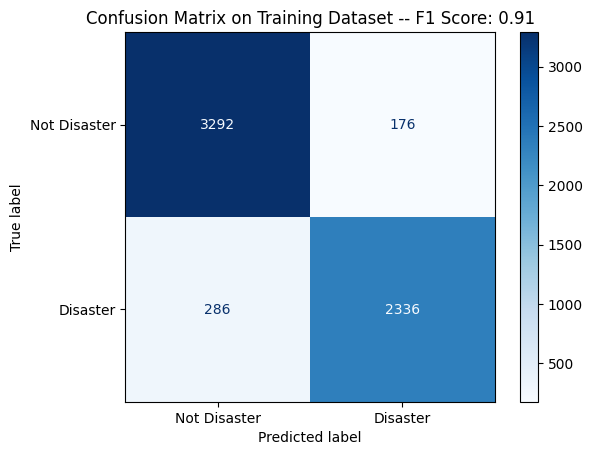

In [44]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


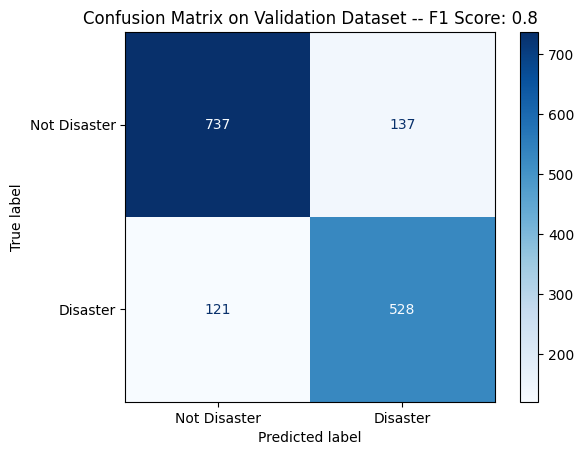

In [45]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [46]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [47]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


In [48]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.430585
std,3146.427221,0.495234
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [49]:
sample_submission.to_csv("submission.csv", index=False)